# barbybar使用例子

In [1]:
%matplotlib inline

In [16]:
from FreeBack import barbybar,post
import copy

# 读取转债数据2018-2023-7

In [4]:
def read_pkl(filename):
    import pickle
    with open(filename,'rb') as file:
        a = pickle.load(file)
        return a

In [12]:
market_convertible = read_pkl('market.pkl')['2023':]

# 当日收盘价作弊买入转股溢价率最低1%转债

In [13]:
def init1(self):
    self.interval = 0
    
# 保持持有转股溢价率最低*只转债，仓位平均
intervals = 1
def strat1(self):
    if self.interval%intervals==0:
        market_ = self.cur_market
        # 低转股溢价率因子
        left = 0.99
        right = 1
        rank = (-market_['premium']).rank()
        factor = rank/rank.max()
        factor = factor[(factor<=right)&(factor>left)]
        basket_hold = list(factor.index)
        self.log("目标持有标的 %s %s"%(len(basket_hold), list(basket_hold)))
        position = self.cur_net/len(basket_hold)

        # 对于持仓， 不在新篮子中则卖出， 在篮子中的卖出至目标仓位
        for code in self.cur_hold_vol.index:
            # 略过缺失（）
            inmarket = True
            try:
                self.cur_market.loc[code]
            except:
                self.log_error('out of market %s'%code)
                inmarket = False
            if inmarket:
                # 卖出
                if code not in basket_hold:
                    # 不在低溢价率组卖出
                    self.log('调出标的 %s'%code)
                    self.sell(code, price = 'close')
                # 调整至目标仓位
                else:
                    hold_vol = self.cur_hold_vol[code]
                    buy_amount = position - hold_vol * self.cur_market['close'].loc[code]
                    buy_vol = buy_amount/self.cur_market['close'].loc[code]
                    if buy_vol > 0:
                        # 下期可交易才加仓
                        if not self.convertible_delist(code, intervals):
                            self.log('加仓 %s'%code)
                            self.buy(code, buy_vol, price='close')
                    else:
                        self.log('减仓 %s'%code)
                        self.sell(code, -buy_vol, price='close')
            # 如果下期无法交易则直接卖出
            if self.convertible_delist(code, intervals):
                self.log('调出标的 %s'%code)
                self.sell(code, price='close')
        # 篮子外的 并且下期可交易
        for code in basket_hold:
            if code not in self.cur_hold_vol.index:
                if not self.convertible_delist(code, intervals):
                    self.log('买入标的 %s'%code)
                    vol = position/self.cur_market['close'].loc[code]
                    self.buy(code, vol, price='close')
    self.interval += 1
                    
            
# 添加策略
barbybar.World.init = init1
barbybar.World.strategy = strat1
# 交易费用为0，限制每根bar成交为总成交量的10%
world0 = barbybar.World(market_convertible, comm=0, max_vol_perbar = 0.1)
world0.cheat_run()

2023-01-03 00:00:00 new bar
2023-01-03 00:00:00 run strategy
2023-01-03 00:00:00 目标持有标的 5 ['123125.SZ', '113615.SH', '123080.SZ', '123060.SZ', '110052.SH']
2023-01-03 00:00:00 买入标的 113615.SH
2023-01-03 00:00:00 买入标的 123080.SZ
2023-01-03 00:00:00 买入标的 123060.SZ
2023-01-03 00:00:00 买入标的 110052.SH
2023-01-03 00:00:00 excute thisbar order
2023-01-03 00:00:00 end bar
2023-01-03 00:00:00 new bar
2023-01-04 00:00:00 run strategy
2023-01-04 00:00:00 目标持有标的 5 ['127058.SZ', '123060.SZ', '110053.SH', '123080.SZ', '113615.SH']
2023-01-04 00:00:00 减仓 123080.SZ
2023-01-04 00:00:00 调出标的 110052.SH
2023-01-04 00:00:00 加仓 113615.SH
2023-01-04 00:00:00 加仓 123060.SZ
2023-01-04 00:00:00 买入标的 127058.SZ
2023-01-04 00:00:00 买入标的 110053.SH
2023-01-04 00:00:00 excute thisbar order
2023-01-04 00:00:00 end bar
2023-01-04 00:00:00 new bar
2023-01-05 00:00:00 run strategy
2023-01-05 00:00:00 目标持有标的 5 ['127058.SZ', '110053.SH', '123060.SZ', '110052.SH', '123080.SZ']
2023-01-05 00:00:00 加仓 110053.SH
2023-01-05 00:00:

2023-02-13 00:00:00 run strategy
2023-02-13 00:00:00 目标持有标的 5 ['128040.SZ', '123105.SZ', '113570.SH', '123134.SZ', '128145.SZ']
2023-02-13 00:00:00 减仓 123134.SZ
2023-02-13 00:00:00 加仓 128145.SZ
2023-02-13 00:00:00 加仓 128040.SZ
2023-02-13 00:00:00 调出标的 127058.SZ
2023-02-13 00:00:00 减仓 123105.SZ
2023-02-13 00:00:00 买入标的 113570.SH
2023-02-13 00:00:00 excute thisbar order
2023-02-13 00:00:00 end bar
2023-02-13 00:00:00 new bar
2023-02-14 00:00:00 run strategy
2023-02-14 00:00:00 目标持有标的 5 ['128040.SZ', '127058.SZ', '110068.SH', '113570.SH', '128145.SZ']
2023-02-14 00:00:00 减仓 128145.SZ
2023-02-14 00:00:00 调出标的 123134.SZ
2023-02-14 00:00:00 减仓 113570.SH
2023-02-14 00:00:00 加仓 128040.SZ
2023-02-14 00:00:00 调出标的 123105.SZ
2023-02-14 00:00:00 买入标的 127058.SZ
2023-02-14 00:00:00 买入标的 110068.SH
2023-02-14 00:00:00 excute thisbar order
2023-02-14 00:00:00 end bar
2023-02-14 00:00:00 new bar
2023-02-15 00:00:00 run strategy
2023-02-15 00:00:00 目标持有标的 5 ['128145.SZ', '113570.SH', '128040.SZ', '123105

2023-03-17 00:00:00 run strategy
2023-03-17 00:00:00 目标持有标的 5 ['123057.SZ', '123118.SZ', '113570.SH', '127057.SZ', '113622.SH']
2023-03-17 00:00:00 加仓 113622.SH
2023-03-17 00:00:00 减仓 113570.SH
2023-03-17 00:00:00 调出标的 110061.SH
2023-03-17 00:00:00 加仓 123057.SZ
2023-03-17 00:00:00 加仓 123118.SZ
2023-03-17 00:00:00 买入标的 127057.SZ
2023-03-17 00:00:00 excute thisbar order
2023-03-17 00:00:00 end bar
2023-03-17 00:00:00 new bar
2023-03-20 00:00:00 run strategy
2023-03-20 00:00:00 目标持有标的 5 ['113595.SH', '127057.SZ', '113570.SH', '123118.SZ', '113622.SH']
2023-03-20 00:00:00 减仓 113622.SH
2023-03-20 00:00:00 调出标的 113622.SH
2023-03-20 00:00:00 调出标的 113570.SH
2023-03-20 00:00:00 加仓 127057.SZ
2023-03-20 00:00:00 调出标的 123057.SZ
2023-03-20 00:00:00 减仓 123118.SZ
2023-03-20 00:00:00 买入标的 113595.SH
2023-03-20 00:00:00 excute thisbar order
2023-03-20 00:00:00 end bar
2023-03-20 00:00:00 new bar
2023-03-21 00:00:00 run strategy
2023-03-21 00:00:00 目标持有标的 5 ['110061.SH', '123118.SZ', '123083.SZ', '127058

2023-04-19 00:00:00 end bar
2023-04-19 00:00:00 new bar
2023-04-20 00:00:00 run strategy
2023-04-20 00:00:00 目标持有标的 5 ['127069.SZ', '110057.SH', '123077.SZ', '127021.SZ', '123118.SZ']
2023-04-20 00:00:00 减仓 123077.SZ
2023-04-20 00:00:00 调出标的 113595.SH
2023-04-20 00:00:00 减仓 127021.SZ
2023-04-20 00:00:00 加仓 110057.SH
2023-04-20 00:00:00 加仓 127069.SZ
2023-04-20 00:00:00 买入标的 123118.SZ
2023-04-20 00:00:00 excute thisbar order
2023-04-20 00:00:00 end bar
2023-04-20 00:00:00 new bar
2023-04-21 00:00:00 run strategy
2023-04-21 00:00:00 目标持有标的 5 ['110057.SH', '127021.SZ', '123077.SZ', '123118.SZ', '123116.SZ']
2023-04-21 00:00:00 加仓 123077.SZ
2023-04-21 00:00:00 加仓 127021.SZ
2023-04-21 00:00:00 减仓 110057.SH
2023-04-21 00:00:00 调出标的 127069.SZ
2023-04-21 00:00:00 减仓 123118.SZ
2023-04-21 00:00:00 买入标的 123116.SZ
2023-04-21 00:00:00 excute thisbar order
2023-04-21 00:00:00 end bar
2023-04-21 00:00:00 new bar
2023-04-24 00:00:00 run strategy
2023-04-24 00:00:00 目标持有标的 5 ['113595.SH', '127021.SZ', '

2023-05-22 00:00:00 目标持有标的 5 ['110057.SH', '128100.SZ', '123148.SZ', '123118.SZ', '113585.SH']
2023-05-22 00:00:00 调出标的 128100.SZ
2023-05-22 00:00:00 减仓 110057.SH
2023-05-22 00:00:00 减仓 123148.SZ
2023-05-22 00:00:00 调出标的 123136.SZ
2023-05-22 00:00:00 减仓 113585.SH
2023-05-22 00:00:00 买入标的 123118.SZ
2023-05-22 00:00:00 excute thisbar order
2023-05-22 00:00:00 end bar
2023-05-22 00:00:00 new bar
2023-05-23 00:00:00 run strategy
2023-05-23 00:00:00 目标持有标的 5 ['113585.SH', '123148.SZ', '127058.SZ', '127028.SZ', '110057.SH']
2023-05-23 00:00:00 加仓 110057.SH
2023-05-23 00:00:00 加仓 123148.SZ
2023-05-23 00:00:00 减仓 113585.SH
2023-05-23 00:00:00 调出标的 123118.SZ
2023-05-23 00:00:00 买入标的 127058.SZ
2023-05-23 00:00:00 买入标的 127028.SZ
2023-05-23 00:00:00 excute thisbar order
2023-05-23 00:00:00 end bar
2023-05-23 00:00:00 new bar
2023-05-24 00:00:00 run strategy
2023-05-24 00:00:00 目标持有标的 5 ['110061.SH', '113585.SH', '110057.SH', '123148.SZ', '123136.SZ']
2023-05-24 00:00:00 加仓 110057.SH
2023-05-24 00:

2023-06-21 00:00:00 run strategy
2023-06-21 00:00:00 目标持有标的 5 ['123098.SZ', '123118.SZ', '123075.SZ', '123092.SZ', '127069.SZ']
2023-06-21 00:00:00 减仓 123075.SZ
2023-06-21 00:00:00 加仓 123098.SZ
2023-06-21 00:00:00 减仓 123092.SZ
2023-06-21 00:00:00 调出标的 118021.SH
2023-06-21 00:00:00 减仓 123118.SZ
2023-06-21 00:00:00 买入标的 127069.SZ
2023-06-21 00:00:00 excute thisbar order
2023-06-21 00:00:00 end bar
2023-06-21 00:00:00 new bar
2023-06-26 00:00:00 run strategy
2023-06-26 00:00:00 目标持有标的 5 ['123075.SZ', '123092.SZ', '123098.SZ', '123118.SZ', '110061.SH']
2023-06-26 00:00:00 减仓 123098.SZ
2023-06-26 00:00:00 调出标的 127069.SZ
2023-06-26 00:00:00 加仓 123075.SZ
2023-06-26 00:00:00 减仓 123092.SZ
2023-06-26 00:00:00 加仓 123118.SZ
2023-06-26 00:00:00 买入标的 110061.SH
2023-06-26 00:00:00 excute thisbar order
2023-06-26 00:00:00 end bar
2023-06-26 00:00:00 new bar
2023-06-27 00:00:00 run strategy
2023-06-27 00:00:00 目标持有标的 5 ['123118.SZ', '128114.SZ', '123098.SZ', '123075.SZ', '123092.SZ']
2023-06-27 00:00:0

### 报错和警告（持仓股被退市、尝试卖出停牌股。。。）

In [14]:
world0.error_log, world0.warning_log

([],
 ['2023-01-30 00:00:00    excute sus----code: 118030.SH, unique:85',
  '2023-01-30 00:00:00    excute sus----code: 127080.SZ, unique:86',
  '2023-01-30 00:00:00    excute sus----code: 111011.SH, unique:87'])

### 策略净值

<Figure size 640x480 with 0 Axes>

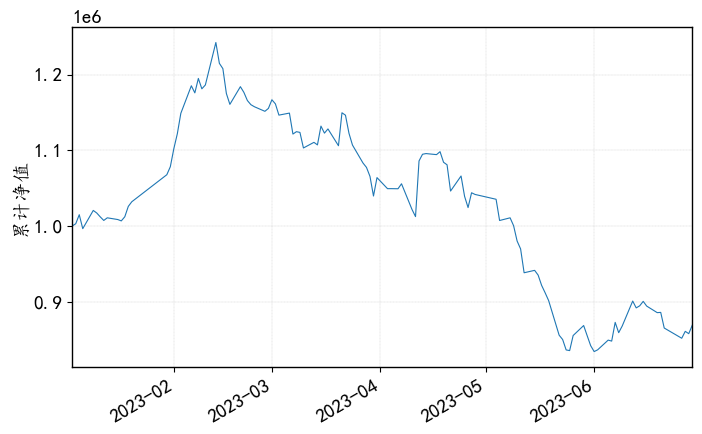

In [17]:
plt, fig, ax = post.matplot()
ax.plot(world0.series_net)
ax.set_ylabel('累计净值')
ax.set_xlim(world0.series_net.index[0], world0.series_net.index[-1])
plt.gcf().autofmt_xdate()

### 每日持仓数据

In [18]:
world0.dict_hold_amount

{Timestamp('2023-01-03 00:00:00'): code
 123080.SZ    200000.0
 110052.SH    200000.0
 113615.SH    200000.0
 123060.SZ    200000.0
 dtype: float64,
 Timestamp('2023-01-04 00:00:00'): code
 123080.SZ    200596.684653
 127058.SZ    200596.684653
 110053.SH    200596.684653
 113615.SH    200596.684653
 123060.SZ    200596.684653
 dtype: float64,
 Timestamp('2023-01-05 00:00:00'): code
 110053.SH    202982.552879
 123080.SZ    202982.552879
 123060.SZ    202982.552879
 127058.SZ    202982.552879
 110052.SH    202982.552879
 dtype: float64,
 Timestamp('2023-01-06 00:00:00'): code
 110053.SH    199291.23663
 123080.SZ    199291.23663
 127058.SZ    199291.23663
 123118.SZ    199291.23663
 123060.SZ    199291.23663
 dtype: float64,
 Timestamp('2023-01-09 00:00:00'): code
 110053.SH    204113.165102
 127058.SZ    204113.165102
 113615.SH    204113.165102
 123118.SZ    204113.165102
 dtype: float64,
 Timestamp('2023-01-10 00:00:00'): code
 123118.SZ    203431.703833
 110053.SH    203431.703833


### 交割单

In [21]:
world0.df_excute

head,date,code,BuyOrSell,price,occurance_vol,occurance_amount,comm,remain_cash,stat,orderprice,ordervol
date,,,,,,,,,,,
0,2023-01-03,113615.SH,Buy,206.362,969.170681,200000.000000,0.0,800000.000000,normal,close,969.170681
1,2023-01-03,123060.SZ,Buy,216.800,922.509225,200000.000000,0.0,600000.000000,normal,close,922.509225
2,2023-01-03,123080.SZ,Buy,147.500,1355.932203,200000.000000,0.0,400000.000000,normal,close,1355.932203
3,2023-01-03,110052.SH,Buy,201.967,990.260785,200000.000000,0.0,200000.000000,normal,close,990.260785
4,2023-01-04,123080.SZ,Sell,151.900,35.348368,5369.417042,0.0,205369.417042,normal,close,35.348368
...,...,...,...,...,...,...,...,...,...,...,...
726,2023-06-29,123092.SZ,Sell,225.511,758.799716,171117.682655,0.0,354644.105695,normal,close,758.799716
727,2023-06-29,118021.SH,Buy,223.419,777.616658,173734.336038,0.0,180909.769657,normal,close,777.616658
728,2023-06-29,127036.SZ,Buy,145.800,1191.593526,173734.336038,0.0,7175.433620,normal,close,1191.593526
